In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd 
%matplotlib inline
sns.set(style='darkgrid')

In [2]:
df1=pd.read_csv('nashville_20190813150235.csv', parse_dates = ['Most Recent Sale Date', 'Sale Date'], dtype={'Zone': str, 'Neighborhood': str})

C:\Users\alehe\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (39) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [16]:
#Creating new dataframe without duplicate entires
df=df1.sort_values(by='Sale Date').drop_duplicates(subset='Map & Parcel', keep = 'last')
#Dropping parcels that were involved in multi-parcel sales
#df=df[df['Multiple Parcels Involved in Sale'] == 'No']
#Want to create a new column which is the mean sale price per square foot of a parcel in that neighborhood
df['PPS']=df['Sale Price']/df['Square Footage Improved']
df['PPS']=df['PPS'].replace(np.inf, np.nan)
meanpps=df.groupby('Neighborhood')['PPS'].mean().to_frame().rename(columns={'PPS':'NeighborhoodPPS'})
df=df.merge(meanpps, how='left', left_on = 'Neighborhood',right_index=True)
df['Month']= df['Sale Date'].dt.month

In [19]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, scale
X= df[['Land Area Acres','Year Built','Square Footage Improved','Month','Story Height','Sale Price', 'Fixtures']].dropna()
data = pd.DataFrame(scale(X), columns=['Land Area Acres','Year Built','Square Footage Improved','Month','Story Height','Sale Price', 'Fixtures'])

pca = PCA(n_components=4).fit(data)
pca_samples= pca.transform(data)
print(data.head())

   Land Area Acres  Year Built  Square Footage Improved     Month  \
0         0.026749   -0.554035                 0.120650 -1.631524   
1        -0.389117    0.997935                -0.499520 -1.631524   
2        -0.389117   -0.084834                -0.086415 -1.631524   
3        -0.389117    0.997935                 0.852555 -1.631524   
4        -0.158080    0.167812                 0.032494 -1.631524   

   Story Height  Sale Price  Fixtures  
0     -0.949496   -0.417738 -1.340158  
1     -0.949496    0.387677  0.054758  
2      0.926547   -0.277741  0.054758  
3     -0.949496   -0.097929  0.612724  
4      0.926547   -0.220655  0.333741  


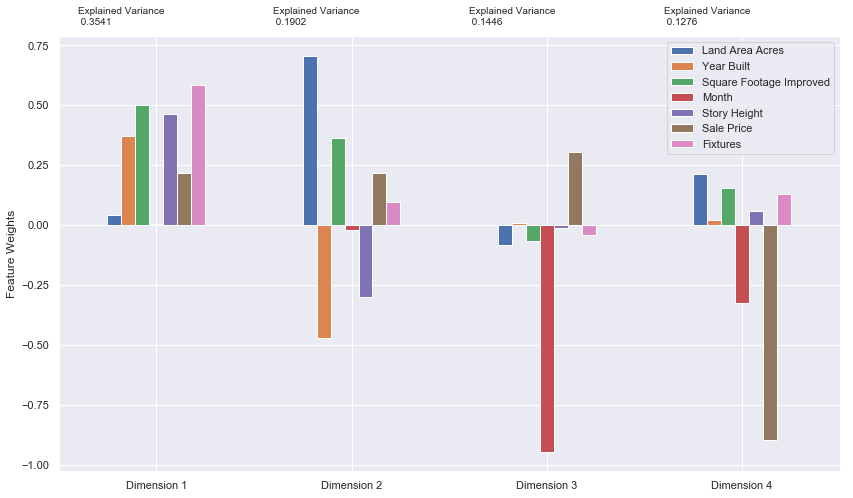

In [20]:
def pca_results(data, pca):
    # Dimension indexing
    dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]
    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = data.keys()) 
    components.index = dimensions
    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1) 
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance']) 
    variance_ratios.index = dimensions
    # Create a bar plot visualization
    fig, ax = plt.subplots(figsize = (14,8))
    # Plot the feature weights as a function of the components
    components.plot(ax = ax, kind = 'bar')
    ax.set_ylabel("Feature Weights") 
    ax.set_xticklabels(dimensions, rotation=0)
    # Display the explained variance ratios# 
    for i, ev in enumerate(pca.explained_variance_ratio_): 
        ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n %.4f"%(ev))
    # Return a concatenated DataFrame
    return pd.concat([variance_ratios, components], axis = 1)

pca_results = pca_results(data, pca)

In [21]:
pca_results.cumsum()

,Explained Variance,Land Area Acres,Year Built,Square Footage Improved,Month,Story Height,Sale Price,Fixtures
Dimension 1,0.3541,0.0408,0.3736,0.5022,0.0052,0.4654,0.2186,0.5849
Dimension 2,0.5443,0.7459,-0.0963,0.8677,-0.0137,0.1636,0.4376,0.6805
Dimension 3,0.6889,0.6648,-0.0888,0.8022,-0.9590,0.1521,0.7439,0.6407
Dimension 4,0.8165,0.8761,-0.0665,0.9570,-1.2845,0.2095,-0.1531,0.7713


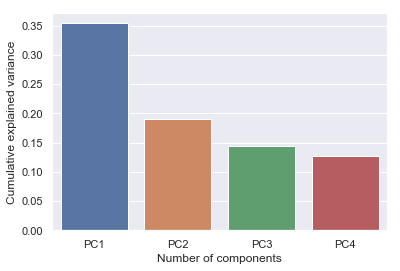

In [22]:
dfvar = pd.DataFrame({'var':pca.explained_variance_ratio_,
             'PC':['PC1','PC2','PC3','PC4']})
sns.barplot(x='PC',y="var",  
           data=dfvar);
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

In [23]:
pca = PCA(n_components=2).fit(data)
reduced_data = pca.transform(data)
pca_samples = pca.transform(data)
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])

In [24]:
def biplot(data, reduced_data, pca):
    fig, ax = plt.subplots(figsize = (14,8))
    # scatterplot of the reduced data 
    ax.scatter(x=reduced_data.loc[:, 'Dimension 1'], y=reduced_data.loc[:, 'Dimension 2'], facecolors='b', edgecolors='b', s=70, alpha=0.5)
    feature_vectors = pca.components_.T
    # using scaling factors to make the arrows
    arrow_size, text_pos = 7.0, 8.0,
    # projections of the original features
    for i, v in enumerate(feature_vectors):
        ax.arrow(0, 0, arrow_size*v[0], arrow_size*v[1], head_width=0.2, head_length=0.2, linewidth=2, color='red')
        ax.text(v[0]*text_pos, v[1]*text_pos, data.columns[i], color='black', ha='center', va='center', fontsize=18)
    ax.set_xlabel("Dimension 1", fontsize=14)
    ax.set_ylabel("Dimension 2", fontsize=14)
    ax.set_title("PC plane with original feature projections.", fontsize=16);
    return ax

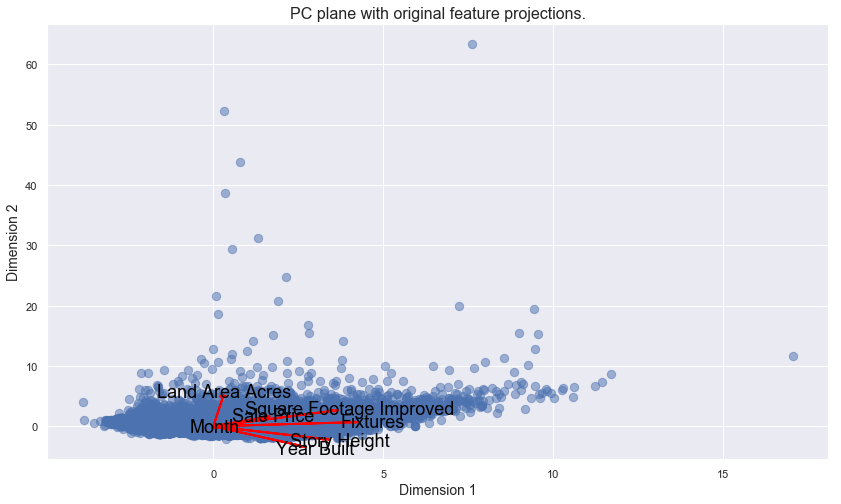

In [25]:
biplot(data, reduced_data, pca)

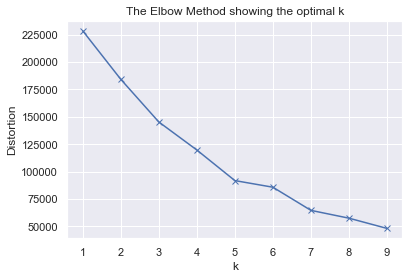

In [15]:
#Determine k using elbow method
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

# k means determine k
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

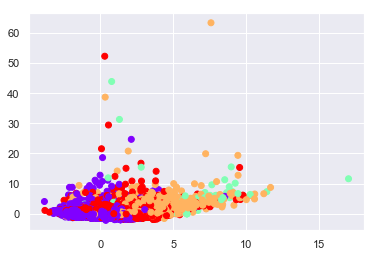

In [27]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=1)
kmeans.fit(X)
centroid = kmeans.cluster_centers_
labels = kmeans.labels_
data['cluster'] = pd.Series(labels)
plt.scatter(reduced_data['Dimension 1'],reduced_data['Dimension 2'], c=kmeans.labels_, cmap='rainbow')